# 决策树
* 决策树简介
* 在数据集中度量一致性
* 使用递归构造决策树
* 使用Matplotlib绘制树形图

## 决策树的构造
决策树
* 优点： 计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据
* 缺点： 可能会产生过拟合问题
* 适用数据类型： 数值型和标称型

一般过程
* 收集数据： 任何方法
* 准备数据： 树构造算法只适用于标称型数据，所以数值型数据必须离散化
* 分析数据： 可使用任何方法，构造树完成后，我们应该检查图形是否符合预期
* 训练算法： 构造树的数据结构
* 测试算法： 使用经验树计算错误率
* 使用算法： 此步骤可适用于任何监督学习算法，而使用决策树也可以更好地理解数据的内在含义

### 分类特征选择
#### 计算熵
$$H(X) = -\sum_{i=1}^n p(x_i)log_2 p(x_i)$$

In [1]:
from math import log

In [2]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    # count prob
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    # count entropy
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

#### 简单的数据集
对海洋生物进行分类

In [3]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [4]:
myDat, labels = createDataSet()

In [5]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [6]:
calcShannonEnt(myDat)

0.9709505944546686

熵越高，混合的数据也越多，尝试在数据集中添加更多分类

In [7]:
myDat[0][-1] = 'maybe'
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [8]:
calcShannonEnt(myDat)

1.3709505944546687

#### 划分数据集
并计算划分后数据集的熵，以便判断当前是否正确地划分了数据集

按照给定特征划分数据集
* dataSet: 待划分的数据集
* axis: 划分数据集的特征
* value: 需要返回的特征的值

解读：
* 由于python本身传递列表引用的特性，所以避免对原始数据重复修改，这里已开始新建了一个列表对象，用来存储按照某特征的特定值进行一次分割后的各条记录
* 首先循环便利原数据寻找到制定特征，然后根据该特征指定的某个值来寻找记录，针对寻找到的多条记录除去其中前面选定列的对应的值，保留其余部分(因为这个特征已经被用来做划分，当前选定的记录的该特征值都是相同的)，如此得到一次划分后的记录并保留到新的列表返回

比如原始数据为`myDat`

no surfacing|flippers|Label
---|---|---
1|1|yes
1|1|yes
1|0|no
0|1|no
0|1|no

执行`splitDataSet(myDat, 0, 1)`后会得到

flippers|Label
---|---
1|yes
1|yes
0|no
即先取出第0列值为1的所有记录，然后取这部分记录除去第0列之外的字段构成新的纪录

同样的，执行`splitDataSet(myDat, 0, 0)`后会得到

flippers|Label
---|---
1|no
1|no

In [20]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

顺便区分下python list中的append和extend

In [11]:
# list append vs. extend
a = [1, 2]
b = [1, 2]
c = [1, 2]
a.extend([3, 4])
print a

[1, 2, 3, 4]


In [13]:
b.append([3, 4])
print b

[1, 2, [3, 4]]


In [12]:
for i in [3, 4]:
    c.append(i)
print c

[1, 2, 3, 4]


In [16]:
myDat, labels = createDataSet()

In [18]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [21]:
splitDataSet(myDat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [22]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]

#### 选择最好的数据集划分方式
遍历整个数据集，循环计算香农熵和调用`splitDataSet`函数划分数据集，找到最好的特征划分方式，注意这里是针对某一数据集的一次划分的最佳特征

解读
* 首先取得所有特征的数目也就是列数
* 然后逐列遍历数据集，首先根据每次选定的特征（列）收集该列的所有可能取值并去重
* 然后根据每个特征不同的取值划分的子数据集可以计算一个熵值，累加即得到数据集按照该特征划分的熵值
* 每次得到一个特征的熵值时计算信息增益，并与当前最大信息增益值比较，若超过则保存并保存对应的特征，最后返回最大信息增益值对应的特征

In [23]:
def chooseBestFeatureToSplit(dataSet):
    # get the number of features(columns),minus 1 for the label
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        # get the unique value of each feature(column)
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        # count the entropy and info gain according to each split of different feature, different value
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob*calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [25]:
chooseBestFeatureToSplit(myDat)

0

递归构建决策树
原理：得到原始数据集，然后基于最好的属性值划分数据集，由于特征值可能多于两个，因此可能存在大于两个分支的数据集划分，第一次划分之后，数据将被向下传递到树分支的下一个节点，在该节点上，我们可以再次划分数据，所以可以采用递归的原则处理数据集
递归结束条件： 程序遍历完所有划分数据集的属性，或者每个分支下的所有实例都具有相同的分类

多数表决方法

_如果数据集已经处理了所有属性，但是类标签依然不是唯一的，此时我们需要决定如何定义该叶子节点（的类别），通常采用多数表决的方法_

In [26]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

创建树
* 获取所有分类，判断当前节点中的样本是否属于同一分类，若是则停止分割
* 判断是否还有特征共划分，若无则返回节点中占大多数的类别作为节点类别
* 开始构建树
    * 选取最佳分类特征以及对应的名称
    * 以选取的特征为键值构建多级字典，然后从特征集合里剔除已被选择的特征
    * 根据选取的特征提取每一条记录对应特征的值得到不重复的特征值集合
    * 根据每一个特征值作为多级字典的内部键递归构建子树

In [29]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    # same class, stop split
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # no feature left, return the majority class
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    # begin to create tree
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [35]:
myDat, labels = createDataSet()

In [40]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [36]:
labels

['no surfacing', 'flippers']

In [38]:
myTree = createTree(myDat, labels)

In [39]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 使用Matplotlib注解绘制树形图

#### 使用文本注解绘制树节点

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

定义文本框和箭头样式

In [42]:
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

In [43]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', xytext=centerPt, 
                            textcoords='axes fraction', va='center', ha='center', bbox=nodeType, 
                            arrowprops=arrow_args)

基础的节点绘制

In [57]:
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

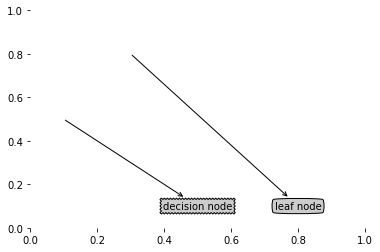

In [46]:
createPlot()

#### 构造注解树
* 获取树的叶节点个数   -->   确定x轴长度
* 获取树的层数        -->   确定y轴长度

In [48]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

In [49]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

另外设置的预先存储的树结构，用于绘图实验

In [50]:
def retrieveTree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}]
    return listOfTrees[i]

In [51]:
myTree = retrieveTree(0)

In [52]:
getNumLeafs(myTree)

3

In [53]:
getTreeDepth(myTree)

2

绘制树
* 绘制路径上的特征值

In [54]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

* 画树

In [55]:
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    
    firstStr = myTree.keys()[0]
    cntrPt = (plotTree.xOff+(1.0+float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [58]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

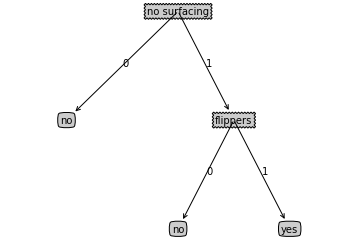

In [59]:
createPlot(myTree)

In [60]:
myTree['no surfacing'][3] = 'maybe'

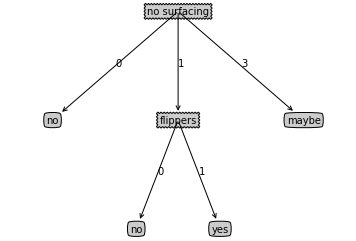

In [61]:
createPlot(myTree)

### 测试和存储分类器
#### 使用决策树执行分类
分类函数： 执行数据分类时，程序比较测试数据与决策树上的数值，递归执行该过程直到进入叶子节点，最后将测试数据定义为叶子节点所属的类型

In [62]:
def classify(inputTree, featLabels, testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [63]:
myDat, labels = createDataSet()

In [64]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [65]:
labels

['no surfacing', 'flippers']

In [66]:
myTree = retrieveTree(0)

In [67]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [68]:
classify(myTree, labels, [1, 0])

'no'

In [69]:
classify(myTree, labels, [1, 1])

'yes'

#### 决策树的存储
使用pickle来序列化对象

In [70]:
import pickle

In [71]:
def storeTree(inputTree, filename):
    fw = open(filename, 'w')
    pickle.dump(inputTree, fw)
    fw.close()

In [72]:
def grabTree(filename):
    fr = open(filename)
    return pickle.load(fr)

In [73]:
storeTree(myTree, 'classifierStorage.txt')

In [74]:
grabTree('classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 使用决策树预测隐形眼镜类型

* 收集数据： 提供的文本文件
* 准备数据： 解析tab键分隔的数据行
* 分析数据： 快速检查数据，确保正确地解析数据内容，使用createPlot()函数绘制最终的树形图
* 训练算法： 使用createTree()函数
* 测试算法： 编写测试函数验证决策树可以正确分类给定的数据实例
* 使用算法： 编写树的存储结构，以便下次使用时无需重新构造树

In [75]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)

In [76]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

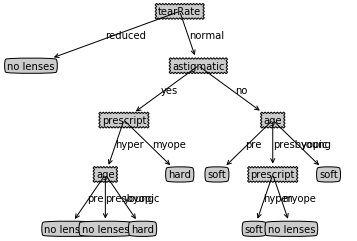

In [77]:
createPlot(lensesTree)

本章仅涉及了算法ID3的决策树生成，关于决策树的剪枝以及算法CART的实现会在第九章进一步讲解